Custom Logistic Regression Accuracy: 0.5003


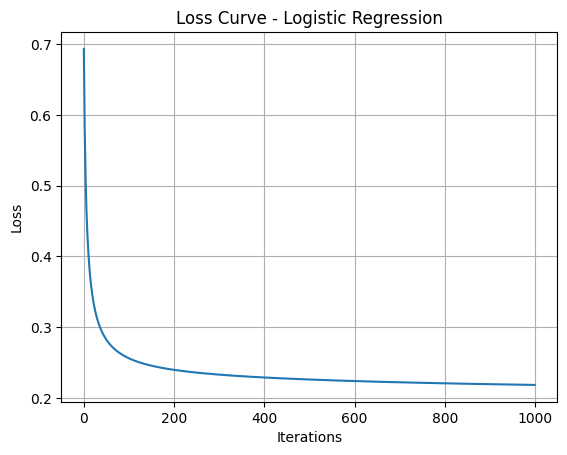

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], errors='ignore')
df = df.replace(-200, np.nan)
df = df.dropna(subset=['CO(GT)'])
df = df.fillna(df.mean(numeric_only=True))

threshold = df['CO(GT)'].median()
df['CO_Level'] = (df['CO(GT)'] > threshold).astype(int)

X = df.drop(columns=['Date', 'Time', 'CO(GT)', 'CO_Level'])
y = df['CO_Level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def remove_highly_correlated_features(X, threshold=0.95):
    corr_matrix = pd.DataFrame(X).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return pd.DataFrame(X).drop(columns=to_drop)

X_train = remove_highly_correlated_features(X_train)
X_test = remove_highly_correlated_features(X_test)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def train_logistic_regression(X, y, learning_rate=0.01, num_iterations=1000, lambda_reg=0.0):
    m, n = X.shape
    X = np.c_[np.ones((m, 1)), X]  
    y = y.reshape(-1, 1)
    weights = np.zeros((n + 1, 1))
    losses = []

    for i in range(num_iterations):
        z = X @ weights
        y_hat = sigmoid(z)

        loss = (-1 / m) * (y.T @ np.log(y_hat + 1e-15) + (1 - y).T @ np.log(1 - y_hat + 1e-15))
        loss += (lambda_reg / (2 * m)) * np.sum(weights[1:] ** 2)  # Don't regularize bias
        losses.append(loss.item())

        gradient = (1 / m) * X.T @ (y_hat - y)
        gradient[1:] += (lambda_reg / m) * weights[1:]

        weights -= learning_rate * gradient

    return weights, losses

def predict(X, weights):
    X = np.c_[np.ones((X.shape[0], 1)), X]
    return (sigmoid(X @ weights) >= 0.5).astype(int)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

weights, losses = train_logistic_regression(
    X_train, y_train.to_numpy(),
    learning_rate=0.1, num_iterations=1000, lambda_reg=0.1
)

y_pred = predict(X_test, weights)
acc = accuracy(y_test.to_numpy(), y_pred)
print(f"Custom Logistic Regression Accuracy: {acc:.4f}")

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curve - Logistic Regression")
plt.grid(True)
plt.show()


Sklearn Logistic Regression Accuracy: 0.9368

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       779
           1       0.94      0.94      0.94       756

    accuracy                           0.94      1535
   macro avg       0.94      0.94      0.94      1535
weighted avg       0.94      0.94      0.94      1535



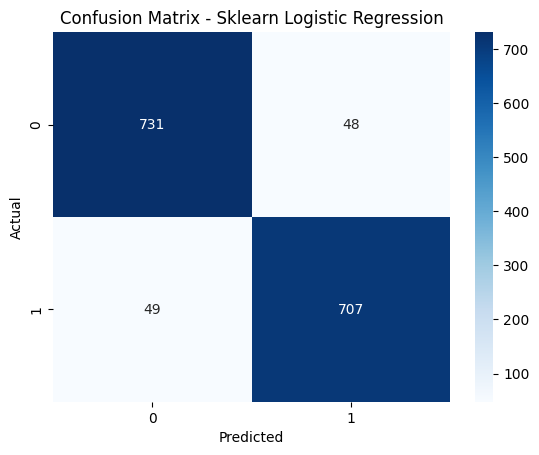

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

y_pred_sklearn = clf.predict(X_test)

acc_sklearn = accuracy_score(y_test, y_pred_sklearn)
print(f"Sklearn Logistic Regression Accuracy: {acc_sklearn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_sklearn))

cm = confusion_matrix(y_test, y_pred_sklearn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sklearn Logistic Regression")
plt.show()


In [9]:
def train_perceptron(X, y, learning_rate=0.01, num_epochs=1000):
    m, n = X.shape
    X = np.c_[np.ones((m, 1)), X]  
    y = y.reshape(-1, 1)
    weights = np.zeros((n + 1, 1))

    for epoch in range(num_epochs):
        for i in range(m):
            xi = X[i].reshape(1, -1)
            yi = y[i]
            prediction = 1 if (xi @ weights)[0, 0] >= 0 else 0
            if prediction != yi:
                weights += learning_rate * (yi - prediction) * xi.T

    return weights

def predict_perceptron(X, weights):
    X = np.c_[np.ones((X.shape[0], 1)), X]
    return (X @ weights >= 0).astype(int)

# Train and evaluate
weights_perceptron = train_perceptron(X_train, y_train.to_numpy(), learning_rate=0.01, num_epochs=10)
y_pred_perceptron = predict_perceptron(X_test, weights_perceptron)
acc_perceptron = accuracy(y_test.to_numpy(), y_pred_perceptron)
print(f"Perceptron Accuracy: {acc_perceptron:.4f}")


Perceptron Accuracy: 0.5003


In [3]:
import numpy as np

class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}

        for cls in self.classes:
            X_cls = X[y == cls]
            self.mean[cls] = X_cls.mean(axis=0)
            self.var[cls] = X_cls.var(axis=0) + 1e-9 
            self.priors[cls] = X_cls.shape[0] / X.shape[0]

    def gaussian_log_pdf(self, x, mean, var):
        return -0.5 * np.sum(np.log(2 * np.pi * var)) - 0.5 * np.sum(((x - mean) ** 2) / var)

    def predict(self, X):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        preds = []
        for x in X:
            posteriors = []
            for cls in self.classes:
                prior = np.log(self.priors[cls])
                log_likelihood = self.gaussian_log_pdf(x, self.mean[cls], self.var[cls])
                posterior = prior + log_likelihood
                posteriors.append(posterior)
            preds.append(np.argmax(posteriors))
        return np.array(preds)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train.to_numpy())
y_pred_gnb = gnb.predict(X_test)

acc_gnb = accuracy(y_test.to_numpy(), y_pred_gnb)
print(f"Naive Bayes Accuracy: {acc_gnb:.4f}")


Naive Bayes Accuracy: 0.9088


SVM Accuracy: 0.9316

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       779
           1       0.93      0.93      0.93       756

    accuracy                           0.93      1535
   macro avg       0.93      0.93      0.93      1535
weighted avg       0.93      0.93      0.93      1535



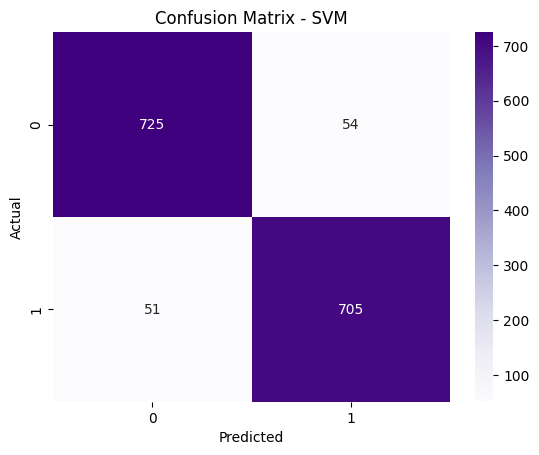

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
acc_svm = accuracy(y_test.to_numpy(), y_pred_svm)
print(f"SVM Accuracy: {acc_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()
